In [1]:
import torch 
import numpy as np
import torchvision 
from torchvision.datasets import MNIST 
from torchvision.transforms import ToTensor 
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline 


In [2]:
dataset = MNIST(root = 'Mdata/', transform= ToTensor())

## 1. indices splitter to split the dataset 

In [3]:
def split_indices(n, pct):
    a = int(n*pct)
    idx = np.random.permutation(n)
    return idx[a:], idx[:a]
    

In [4]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([1, 28, 28]) 5


5


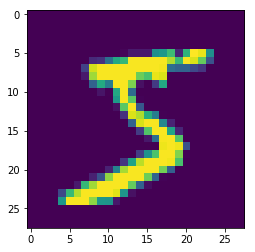

In [5]:
plt.imshow(img[0])
print(label)

In [6]:
train_idx, val_idx = split_indices(len(dataset), pct=0.2)
print(len(train_idx), len(val_idx))

48000 12000


## 2. Defining the samplers and data loaders and batch size

In [23]:
batch_size = 100 
# We pick random samples. It will sample from the ones it hasnt seen.    
train_sampler = SubsetRandomSampler(train_idx)
train_dl = DataLoader(dataset, batch_size, sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_idx)
valid_dl = DataLoader(dataset, batch_size, sampler=val_sampler)


## 3. Model! 
In this we will use a simple feed forward neural network with one hidden layer.  

The linear regressor is a neural net with no hidden layer. Each output neuron takes 784 inputs, gives a weight to each of them and mapps to an output. 784*10 weights and 10 biases

By using a fully connected layer with a non-linear activation function, we get a non-linear mapping so we can find non linear relationships in our model. 

* The first layer will output 32 or 64 elements. 
* The second layer is the output, mapps the 64 inputs into 10 labels. 
 

In [8]:
import torch.nn.functional as F 
import torch.nn as nn 



In [9]:
for xb, yb in train_dl:
    print(xb.shape)
    print(xb.reshape(xb.size(0),-1).shape)
    break

torch.Size([100, 1, 28, 28])
torch.Size([100, 784])


In [10]:
class MnistModel(nn.Module):
    def __init__(self, in_size, hidden_size,out_size):
        super().__init__()
        
        # hidden layer 
        self.linear1 = nn.Linear(in_size, hidden_size)
        
        # output layer 
        self.linear2 = nn.Linear(hidden_size, out_size)
    def forward(self, xb):
        # First flatten the image. the -1 will force it to compute whatever number will result in the same number of elements. 
        xb = xb.view(xb.size(0),-1)
        
        a = self.linear1(xb)
        
        out = F.relu(a)
        
        # get predictions using output layer
        
        out = self.linear2(out)
        
        return out 
    
        
        

### See whats going on with the model 


In [11]:
input_size = 784
num_classes = 10 
model = MnistModel(input_size, hidden_size=32, out_size=10)
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [12]:
for images, labels in train_dl:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print("loss: ", loss)
    break 

loss:  tensor(2.3296, grad_fn=<NllLossBackward>)


## loss_batch : this is the training step 

calculates the loss, metrics and performs a gradient descent step

In [43]:
def loss_batch(model, xb, yb, loss,opt=None,metrics=None):
    preds = model(xb)
    cost = loss(preds, yb)
    num  = len(xb)
    if opt is not None:
        cost.backward()
        opt.step()
        opt.zero_grad()
    metrics_result = None
    if metrics is not None:
        metrics_result = metrics(preds, yb)
    return cost, num, metrics_result
    
    
    

In [55]:
def evaluation(model, loss, eval_dl, metrics):
    with torch.no_grad():
        results = [loss_batch(model,xb,yb,loss,metrics=metrics) for xb, yb in eval_dl]
        costs, nums, metrics_result = zip(*results)
        total = np.sum(nums)
        average_cost = np.sum(np.multiply(costs,nums))/total
        
        average_metrics_result = None 
        if metrics is not None:
            
            average_metrics_result = np.sum(np.multiply(metrics_result,nums))/total
        
    return average_cost, total, average_metrics_result
        
def accuracy(preds, yb):
    _, locs = torch.max(preds,dim =1)
    return torch.sum(locs ==yb)/len(preds)

In [51]:
for images, labels in train_dl:
    cost, num, metric_result = loss_batch(model,loss=F.cross_entropy,metrics=accuracy,opt=None,xb=images,yb=labels)

    break 

In [68]:
def fit(epochs,lr, model, loss_fn, train_dl, eval_dl,opt_fn=None, metrics=None):
    if opt_fn is None: opt_fn = torch.optim.SGD
    loss_list =[]
    metric_list=[]
    opt = opt_fn(model.parameters(), lr = lr)
        
    for epoch in range(epochs): 
        for xb, yb in train_dl:
            loss, _,_ =loss_batch(model,xb,yb,loss_fn,opt,metrics)
        
        val_loss, total, val_metric  = evaluation(model,loss_fn,eval_dl, metrics) 
        
        # record the loss and metric
        loss_list.append(val_loss)
        metric_list.append(val_metric)
        
        if metrics is None:
            print("epoch %d / %d , loss is %.4f" %(epoch, epochs, val_loss))
        else:
            print("epoch %d / %d, loss is %.4f, %s is %.4f" % (epoch, epochs, val_loss, metrics.__name__, val_metric))
    return loss_list, metric_list

## Using a GPU
GPU has many cores, which is optimized for performing expensive matrix multiplications. We need to create a function to ensure the code uses the GPU if available, and the CPU if GPU isnt. 



In [15]:
torch.cuda.is_available()

True

In [16]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else: 
        return torch.device("cpu")

In [17]:
device = get_default_device()
device

device(type='cuda')

### moving data and model to a chosen device 

In [18]:
def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking = True)

In [19]:
to_device([torch.tensor([1.,2.,3.,4.]), torch.tensor([2.,3.,5.,6.])], "cpu")

[tensor([1., 2., 3., 4.]), tensor([2., 3., 5., 6.])]

In [20]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, "cpu")
    print(images[0].device)
    break

torch.Size([100, 1, 28, 28])
cpu


We want to load data to the GPU, but not all at once. we need a class to do this.


In [21]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl 
        self.device = device
    def __iter__(self):
        for b in self.dl:
            # this returns the result for that iteration and breaks. The next time the funcion is called, it will continue to 
            # yield the next one. 
            yield to_device(b,self.device)
            # we don't need to worry about moving things off the GPU. Automatic garbage collection happens. 
    def __len__(self):
        return len(self.dl)

In [24]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl,device)

In [25]:
for xb, yb in valid_dl:
    print("xb.device:", xb.device)
    break

xb.device: cuda:0


In [29]:
model = MnistModel(input_size, hidden_size=32, out_size= num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [59]:
val_loss, total, val_acc = evaluation(model, F.cross_entropy, valid_dl, metrics=accuracy)
print(val_loss, val_acc)

tensor(2.3067, device='cuda:0') tensor(0.1336, device='cuda:0')


In [69]:
losses1, metrics1 = fit(5,0.1, model, F.cross_entropy, train_dl, valid_dl, metrics=accuracy)

epoch 0 / 5, loss is 0.1593, accuracy is 0.9527
epoch 1 / 5, loss is 0.1508, accuracy is 0.9563
epoch 2 / 5, loss is 0.1446, accuracy is 0.9582
epoch 3 / 5, loss is 0.1394, accuracy is 0.9596
epoch 4 / 5, loss is 0.1369, accuracy is 0.9598
